In [4]:
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.morphology import disk
from bilateral import *

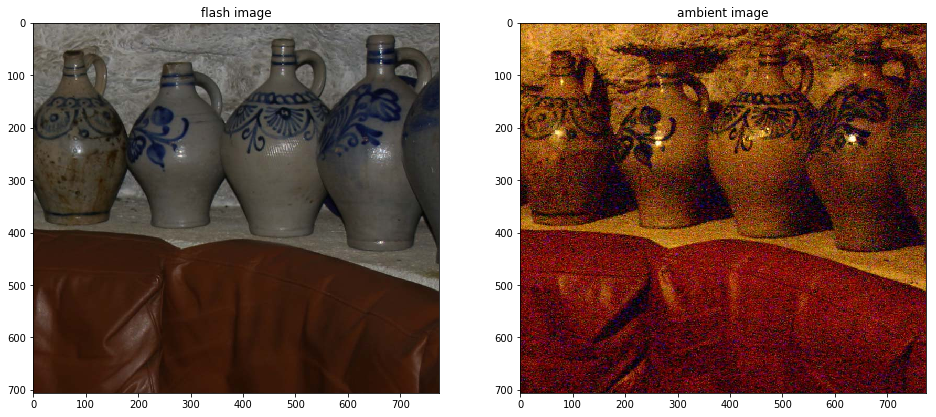

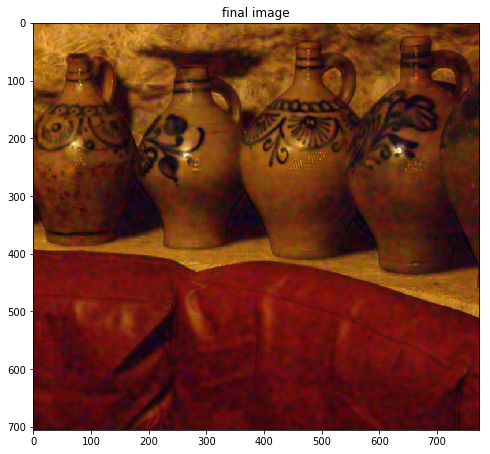

In [40]:
flash_files = ['./dataset/cave01_00_flash.jpg']
# , './dataset/carpet_00_flash.jpg', './dataset/potsdetail_00_flash.jpg', './dataset/puppets_00_flash.jpg', './dataset/lamp_00_flash.jpg']
amb_files = ['./dataset/cave01_01_noflash.jpg']
# , './dataset/carpet_01_noflash.jpg', './dataset/potsdetail_01_noflash.jpg', './dataset/puppets_01_noflash.jpg', './dataset/lamp_01_noflash.jpg']
# ref_files = ['./dataset/cave01_04_reference.jpg'] 
for i in range(0,1):
    flash_img = cv2.imread(flash_files[i])
    amb_img = cv2.imread(amb_files[i])
#     ref_img = cv2.imread(ref_files[i])
    
    flash_img = cv2.cvtColor(flash_img, cv2.COLOR_BGR2RGB)
    amb_img = cv2.cvtColor(amb_img, cv2.COLOR_BGR2RGB)
#     ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

    flash_img = flash_img.astype('double')/255
    amb_img = amb_img.astype('double')/255
    
    # shadow mask
    linflash = 0.299*flash_img[:,:,0] + 0.587*flash_img[:,:,1] + 0.114*flash_img[:,:,2]
    linambient = 0.299*amb_img[:,:,0] + 0.587*amb_img[:,:,1] + 0.114*amb_img[:,:,2]
    mask = linflash - linambient
    flag = np.zeros((mask.shape), np.uint8)
    thr1 = -0.05
    thr2 = -0.2 
    flag[(mask > thr2) & (mask < thr1)] = 1
    flag[(mask > 0.65) & (mask < 0.7)] = 1
    rang = 0.95*(np.max(linflash) - np.min(linflash))
    flag[linflash > rang] = 1


    se1 = disk(2)
    se2 = disk(6)
    se3 = disk(4)
    flag = cv2.erode(flag, se1, iterations = 1)
    maskff = np.zeros((flag.shape[0]+2, flag.shape[1]+2), np.uint8)
    cv2.floodFill(flag, maskff, (0,0), 1)
    maskff = 1 - maskff

    maskff = cv2.dilate(maskff, se2  )
    maskff = cv2.erode(maskff, se3 )
    maskff = maskff.astype('double')
    kernel = np.array([[0.1070, 0.1131, 0.1070],
    [0.1131,    0.1196,    0.1131],
    [0.1070,    0.1131,    0.1070]])
    maskff = cv2.filter2D(maskff, -1, kernel)
    shadowMask = maskff[:-2,:-2]
    
    fr = flash_img[:,:,0]
    fg = flash_img[:,:,1]
    fb = flash_img[:,:,2]

    [Ajointr, Abaser, Fbaser] = bilateral(fr, amb_img[:,:,0])
    [Ajointg, Abaseg, Fbaseg] = bilateral(fg, amb_img[:,:,1])
    [Ajointb, Abaseb, Fbaseb] = bilateral(fb, amb_img[:,:,2])

    Ajoint = np.dstack((Ajointr, Ajointg, Ajointb))
    Abase = np.dstack((Abaser, Abaseg, Abaseb))
    Fbase = np.dstack((Fbaser, Fbaseg, Fbaseb))

    eps = 0.02;
    Fdetailr = (fr + eps)/(Fbaser + eps)
    Fdetailg = (fg + eps)/(Fbaseg + eps)
    Fdetailb = (fb + eps)/(Fbaseb + eps)
    Fdetail = np.dstack((Fdetailr, Fdetailg, Fdetailb))
    
    shadowMask = 0
    Ffin = (np.dstack(((1-shadowMask), (1-shadowMask), (1-shadowMask)))*(Ajoint*Fdetail) + np.dstack((shadowMask, shadowMask, shadowMask))*(Abase))
    
    Ffin[Ffin>1] = 1
    Fdetail[Fdetail>1] = 1
        
    fig = plt.figure(figsize = [16, 16])
    fig.add_subplot(1, 2, 1)
    plt.imshow(flash_img, cmap='gray')
    plt.title('flash image')
    fig.add_subplot(1, 2, 2)
    plt.title('ambient image')
    plt.imshow(amb_img)
    
    fig = plt.figure(figsize = [8, 8])
    fig.add_subplot(1, 1, 1)
    plt.imshow(Ffin, cmap='gray')
    plt.title('final image')
#     fig.add_subplot(1, 2, 2)
#     plt.title('Shadow image')
#     plt.imshow(shadowMask, cmap='gray')
    

Text(0.5,1,'Detail Transfer image')

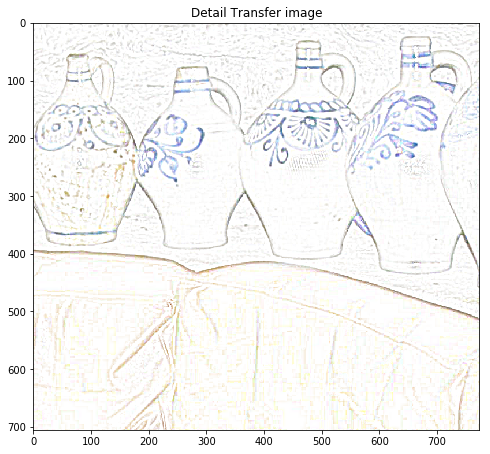

In [41]:
fig = plt.figure(figsize= [8, 8])
plt.imshow(Fdetail, cmap='gray')
plt.title('Detail Transfer image')
